Run batch file to download monthly weather data from the [Danish Meteorological Institute](
https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-08.pdf)

In [ ]:
!cd ../data/air/ & air_download.bat

Load data and calculate anomalies in surface air temperature

In [18]:
import glob
import os

import pandas as pd
import pyproj
import xarray as xr

# Tweak column names based on Table 1 here:
# https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-08.pdf
COL_NAMES = {
    "Station": "station_id",
    "Year": "year",
    "Month": "month",
    "Day": "day",
    "Hour(utc)": "hour",
    "101": "mean_air_temp_degc",
}

# Metadata for final Dataset
GLOBAL_ATTRS = {
    "author": "Jensen, C. D.",
    "institution": "Danish Meteorological Institute (DMI)",
    "projection": "3413",
    "title": "Weather Observations from Greenland 1958-2023",
    "version": "08 February 2024",
    "data_description": "https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-08.pdf",
}
VAR_ATTRS = {
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
    "glacier": {
        "description": "Initials of glacier name",
    },
    "station_id": {
        "description": "6-digit station number",
    },
    "height": {
        "description": "Height of weather station above mean sea level",
        "units": "metres",
    },
    "t_monthly": {
        "description": "Monthly mean of hourly mean air temperature, measured 2m above ground",
        "units": "degrees celcius",
    },
    "t_anomalies": {
        "description": "Anomalies in monthly mean air temperature calculated relative to a 1988-2024 baseline",
        "units": "degrees celcius",
    },
}

# Collect weather station data files and load station metadata
files = [f for f in glob.glob(f"../data/air/*00.csv")]
station_details = pd.read_excel(f"../data/air/station_metadata.xlsx")

# Container for final Datasets
t_ds = []

# Process weather data for each station in turn
for f in files:
    # Extract station metadata
    station_id = int(os.path.splitext(os.path.basename(f))[0])
    station_meta = (
        station_details.loc[station_details["Station number"] == station_id]
        .sort_values(by="Start date")
        .iloc[-1]
    )
    station_height = station_meta.Height

    # Transform coords to EPSG:3413
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3413")
    station_x, station_y = transformer.transform(station_meta.Latitude, station_meta.Longitude)

    # Generate glacier code based on which file is being processed -
    # requires knowledge of which file maps to which site
    glacier = "DAUGAARD-JENSEN" if station_id == 433900 else "UNNAMED_UUNARTIT_ISLANDS"

    # Load weather data, add meaningful labels, and drop empty parameters
    air_df = pd.read_csv(f, delimiter=";")
    air_df = air_df.rename(columns=COL_NAMES)
    air_df = air_df.dropna(axis="columns", how="all")

    # Construct and set datetime index from individual date and time components
    air_df["time"] = pd.to_datetime(air_df[["year", "month", "day", "hour"]])
    air_df = air_df.set_index("time")

    # Convert DataFrame to xarray.Dataset
    air_ds = air_df.to_xarray()

    # Define baseline period - chosen here as the period of overlap
    # between data from both stations
    baseline = slice("1988-01-01", "2024-01-01")

    # Calculate monthly average, baseline average, and time series anomalies
    t_monthly = air_ds.mean_air_temp_degc.resample(time="1MS").mean()
    t_baseline = t_monthly.sel(time=baseline).groupby("time.month").mean()
    t_anomalies = t_monthly.groupby("time.month") - t_baseline

    # Merge mean and anomalies into single Dataset
    t_monthly = t_monthly.to_dataset(name="t_monthly")
    t_anomalies = t_anomalies.drop_vars("month").to_dataset(name="t_anomalies")
    _t_ds = xr.combine_by_coords([t_monthly, t_anomalies])

    # Assign station metadata and coordinate/variable attributes
    _t_ds = _t_ds.assign_coords(
        station_id=("station_id", [station_id], VAR_ATTRS["station_id"]),
        glacier=("station_id", [glacier], VAR_ATTRS["glacier"]),
        x=("station_id", [station_x], VAR_ATTRS["x"]),
        y=("station_id", [station_y], VAR_ATTRS["y"]),
        height=("station_id", [station_height], VAR_ATTRS["height"]),
    )
    _t_ds = _t_ds.swap_dims({"station_id": "glacier"})
    _t_ds["t_monthly"] = _t_ds.t_monthly.assign_attrs(VAR_ATTRS["t_monthly"])
    _t_ds["t_anomalies"] = _t_ds.t_anomalies.assign_attrs(VAR_ATTRS["t_anomalies"])
    t_ds.append(_t_ds)

# Merge Datasets station-wise, assign global attributes, and write to disk
t_ds = xr.combine_by_coords(t_ds)
t_ds = t_ds.assign_attrs(GLOBAL_ATTRS)
t_ds.to_netcdf(f"../data/air/air_temp_monthly_1980_2024.nc")
t_ds

<xarray.Dataset> Size: 21kB
Dimensions:      (glacier: 2, time: 519)
Coordinates:
  * time         (time) datetime64[ns] 4kB 1980-11-01 1980-12-01 ... 2024-01-01
  * glacier      (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUNARTIT_ISLA...
    station_id   (glacier) int32 8B 433900 435100
    x            (glacier) float64 16B 8.355e+05 5.363e+05
    y            (glacier) float64 16B -1.964e+06 -2.377e+06
    height       (glacier) float64 16B 70.0 12.0
Data variables:
    t_anomalies  (glacier, time) float64 8kB -4.666 -7.972 ... -2.358 1.985
    t_monthly    (glacier, time) float64 8kB -13.57 -20.1 ... -9.669 -6.776
Attributes:
    author:            Jensen, C. D.
    institution:       Danish Meteorological Institute (DMI)
    projection:        3413
    title:             Weather Observations from Greenland 1958-2023
    version:           08 February 2024
    data_description:  https://www.dmi.dk/fileadmin/Rapporter/2024/DMIRep24-0...

Quick visualisation of surface air temperature anomaly time series

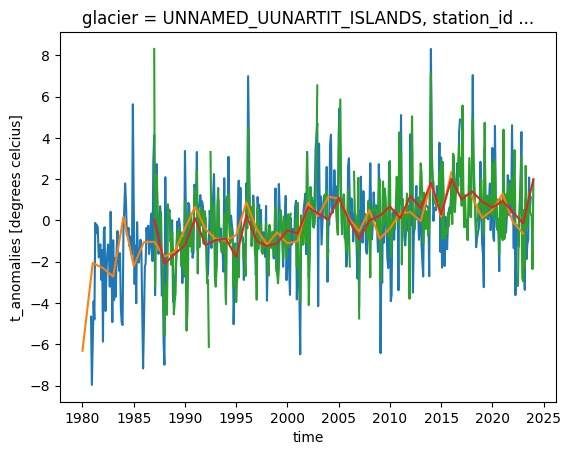

In [19]:
for _, ds in t_ds.groupby("glacier", squeeze=False):
    ds.t_anomalies.plot()
    ds.t_anomalies.resample(time="1YS").mean().plot(zorder=10)